## Tunning dos hiperparâmetros
- Será realizado o tunning para os seguintes casos:
    1) sem informações do WHOQOL na base
    2) com todas as respostas do WHOQOL
    3) só com o índice final do WHOQOL
    4) só com os índices dos domínios do WHOQOL

- Para os seguintes modelos:
    1) Random Forest
    2) SVM
    3) MLP
    4) XGBoost

#### Workflow:
Para cada caso:
- Importar dados
- Separar em treino e teste ( Preciso
- Definir os parâmetros a serem testados
- Realizar o tunning
- Salvar os resultados graficamente
- Salvar o melhor modelo

### Importando as bibliotecas

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from tpot import TPOTClassifier
import os
import pickle
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns

#Importando modelo Dummy:
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings('ignore')

### Definindo a função

In [4]:
def perform_model_tuning(data, target, models, param_grids, base_name):
    # Dividir os dados em treinamento e teste após o Random Under-Sampling
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    best_models = {}  # Dicionário para armazenar o melhor modelo de cada tipo
    model_accuracies = {}  # Dicionário para armazenar as acurácias de cada modelo
    current_dir = os.getcwd()
    for model_name, model, param_grid_entry in zip(models.keys(), models.values(), param_grids):
        print(f"Tuning do modelo {model_name} iniciado...")

        # Acessar o dicionário de parâmetros correspondente ao modelo atual
        param_grid = param_grid_entry['params']

        # Realizar a busca em grid para encontrar os melhores parâmetros
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Melhor modelo encontrado
        best_model = grid_search.best_estimator_

        # Fazer previsões no conjunto de teste
        y_pred = best_model.predict(X_test)

        # Calcular a acurácia do modelo
        accuracy = accuracy_score(y_test, y_pred)
        model_accuracies[model_name] = accuracy

        print(f"Acurácia do modelo {model_name}: {accuracy:.4f}")

        # Salvar o melhor modelo
        best_models[model_name] = best_model

    # Plotar gráfico de desempenho comparativo
    plt.figure(figsize=(10, 6))
    plt.bar(model_accuracies.keys(), model_accuracies.values())
    plt.xlabel('Modelos')
    plt.ylabel('Acurácia')
    plt.title('Comparação de desempenho dos modelos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    graph_filename = f"{base_name}_graph_{model_name}.png"
    graph_path = os.path.join(current_dir, graph_filename)
    plt.savefig(graph_path)
    plt.close()


    #Pickle the single best model, verifying the best and saving from best_models dict, se tiver mais algo salvo com o mesmo nome, adiciona mais um.
    best_model = max(model_accuracies, key=model_accuracies.get)
    best_model = best_models[best_model]
    if os.path.exists(f"{base_name}_best_model.pkl"):
        i = 1
        while os.path.exists(f"{base_name}_best_model_{i}.pkl"):
            i += 1
        pickle.dump(best_model, open(f"{base_name}_best_model_{i}.pkl", "wb"))
    else:
        pickle.dump(best_model, open(f"{base_name}_best_model.pkl", "wb"))
    # Salvar tabela com os valores de acurácia
    table_filename = f"{base_name}_table_{model_name}.csv"
    accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Acurácia'])
    table_path = os.path.join(current_dir, table_filename)
    accuracies_df.to_csv(table_path, index=False)

    return best_models

### Importando os dados

In [5]:
# Sem WHOQOL:
base1 = pd.read_csv('Datasets/dataframe_socioeconomico_Niveis.csv')
data1 = base1.drop('Nivel_MHI', axis=1)
target1 = base1['Nivel_MHI']
le = LabelEncoder()
target1 = le.fit_transform(target1)

# Realizar Random Under-Sampling
sampler = RandomUnderSampler()
data1_re, target1_re = data1, target1


# com todas as respostas do WHOQOL
base2 = pd.read_csv('Datasets/df_social_whoqol_tratado_1.csv')
data2 = base2.drop('Nivel_MHI', axis=1)
target2 = base2['Nivel_MHI']
target2 = le.fit_transform(target2)
sampler = RandomUnderSampler()
data2_re, target2_re = data2, target2


# só com o indice dos dominiosdo WHOQOL, concatenar base1 com final da base2
data3 = pd.concat([data1, base2.loc[:,['CR','CS','CT','CU']]], axis=1)
target3 = base2['Nivel_MHI']
target3 = le.fit_transform(target3)
sampler = RandomUnderSampler()
data3_re, target3_re = data3, target3


# Só com a qualidade de vida do WHOQOL
data4 = pd.concat([data1, base2['BR']], axis=1)
target4 = base2['Nivel_MHI']
target4 = le.fit_transform(target4)
sampler = RandomUnderSampler()
data4_re, target4_re = data4, target4

# Qualidade de Vida Geral ( Media das duas primeiras questões do WHOQOL)
# Pegar a média das duas primeiras colunas da base2, pelo indice
data5 = pd.concat([data1, base2.loc[:,['BR','BS']].mean(axis=1)], axis=1)
target5 = base2['Nivel_MHI']
target5 = le.fit_transform(target5)
sampler = RandomUnderSampler()
data5.columns = data5.columns.astype(str)
data5_re, target5_re = data5, target5

# Media de todos os dominios do WHOQOL
data6 = pd.concat([data1, base2.loc[:,['CR','CS','CT','CU']].mean(axis=1)], axis=1)
target6 = base2['Nivel_MHI']
target6 = le.fit_transform(target6)
sampler = RandomUnderSampler()
data6.columns = data6.columns.astype(str)
data6_re, target6_re = data6, target6



In [6]:
# Dividir os dados em treino e teste
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1_re, target1_re, test_size=0.2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2_re, target2_re, test_size=0.2)
X_train3, X_test3, y_train3, y_test3 = train_test_split(data3_re, target3_re, test_size=0.2)
X_train4, X_test4, y_train4, y_test4 = train_test_split(data4_re, target4_re, test_size=0.2)
X_train5, X_test5, y_train5, y_test5 = train_test_split(data5_re, target5_re, test_size=0.2)
X_train6, X_test6, y_train6, y_test6 = train_test_split(data6_re, target6_re, test_size=0.2)


In [5]:
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_input, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_input, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)


# Função que chama os 4 modelos e retorna o resultado de cada um usando a função avalia_modelo_cv e imprime o resultado de cada um.

def avalia_dif_modelos_cv(X_train, y_test, cv):
    # Criando os modelos
    dummy_av = DummyClassifier(strategy='most_frequent')
    rf_av = RandomForestClassifier(n_jobs=-1)
    svm_av = SVC(kernel='rbf', gamma='auto', decision_function_shape='ovo')
    mlp_av = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
    xgb_av = XGBClassifier(n_jobs=-1)

    # Aplicando a função de avaliação
    dummy_fun_av = avalia_modelo_cv(dummy_av, X_train, y_test, cv)
    rf_fun_av = avalia_modelo_cv(rf_av, X_train, y_test, cv)
    svm_fun_av = avalia_modelo_cv(svm_av, X_train, y_test, cv)
    mlp_fun_av = avalia_modelo_cv(mlp_av, X_train, y_test, cv)
    xgb_fun_av = avalia_modelo_cv(xgb_av, X_train, y_test, cv)

    # Criando o dataframe com os resultados
    df_resultado = pd.DataFrame({'Modelo': ['Dummy', 'RF', 'SVM', 'MLP', 'XGB'],
                                 'Acurácia': [dummy_fun_av, rf_fun_av, svm_fun_av, mlp_fun_av, xgb_fun_av]})

    # Plotando o gráfico de barras
    sns.barplot(x='Modelo', y='Acurácia', data=df_resultado)
    plt.show("Desempenho dos modelos")
    %matplotlib inline

    return df_resultado

## Avaliando modelos sem Under-Sampling

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.00      0.00      0.00       149
           2       0.66      1.00      0.79       574

    accuracy                           0.66       872
   macro avg       0.22      0.33      0.26       872
weighted avg       0.43      0.66      0.52       872



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.62      0.07      0.12       149
           2       0.66      0.98      0.79       574

    accuracy                           0.65       872
   macro avg       0.43      0.35      0.30       872
weighted avg       0.54      0.65      0.54       872

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.00      0.00      0.00       149
           2       0.66      1.00      0.79       574

    accuracy                           0.66       872
   macro avg       0.22      0.33      0.26       872
weighted avg       0.43      0.66      0.52       872

-------------------------------

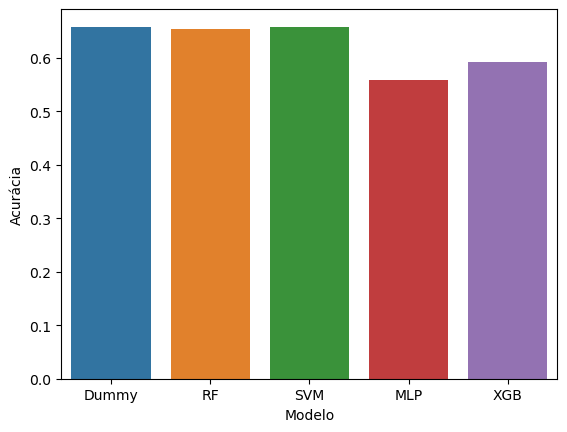

,Modelo,Acurácia
0,Dummy,0.658257
1,RF,0.654817
2,SVM,0.658257
3,MLP,0.558486
4,XGB,0.592890


In [6]:
avalia_dif_modelos_cv(data1, target1, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.00      0.00      0.00       149
           2       0.66      1.00      0.79       574

    accuracy                           0.66       872
   macro avg       0.22      0.33      0.26       872
weighted avg       0.43      0.66      0.52       872

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.44      0.55       149
           1       0.78      0.56      0.65       149
           2       0.78      0.92      0.84       574

    accuracy                           0.78       872
   macro avg       0.77      0.64      0.68       872
weighted avg       0.77      0.78      0.76       872

-------------------

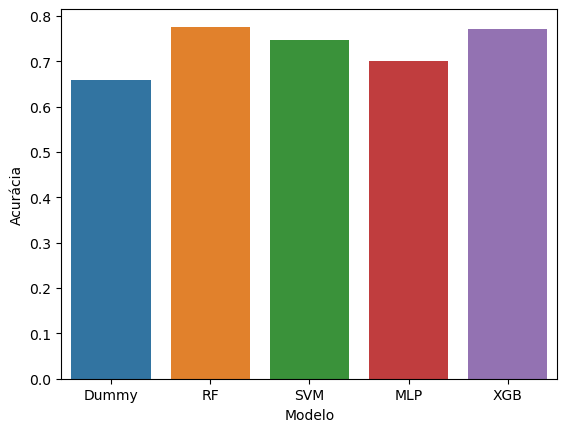

,Modelo,Acurácia
0,Dummy,0.658257
1,RF,0.776376
2,SVM,0.746560
3,MLP,0.700688
4,XGB,0.771789


In [7]:
avalia_dif_modelos_cv(data2, target2, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.00      0.00      0.00       149
           2       0.66      1.00      0.79       574

    accuracy                           0.66       872
   macro avg       0.22      0.33      0.26       872
weighted avg       0.43      0.66      0.52       872

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.34      0.46       149
           1       0.78      0.49      0.60       149
           2       0.75      0.93      0.83       574

    accuracy                           0.75       872
   macro avg       0.75      0.59      0.63       872
weighted avg       0.75      0.75      0.73       872

-------------------

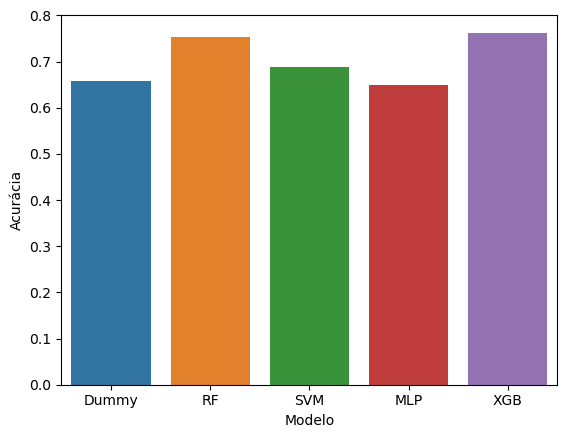

,Modelo,Acurácia
0,Dummy,0.658257
1,RF,0.753440
2,SVM,0.688073
3,MLP,0.649083
4,XGB,0.762615


In [8]:
avalia_dif_modelos_cv(data3, target3, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.00      0.00      0.00       149
           2       0.66      1.00      0.79       574

    accuracy                           0.66       872
   macro avg       0.22      0.33      0.26       872
weighted avg       0.43      0.66      0.52       872

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.01      0.01       149
           1       0.62      0.13      0.22       149
           2       0.67      0.97      0.79       574

    accuracy                           0.67       872
   macro avg       0.51      0.37      0.34       872
weighted avg       0.59      0.67      0.56       872

-------------------

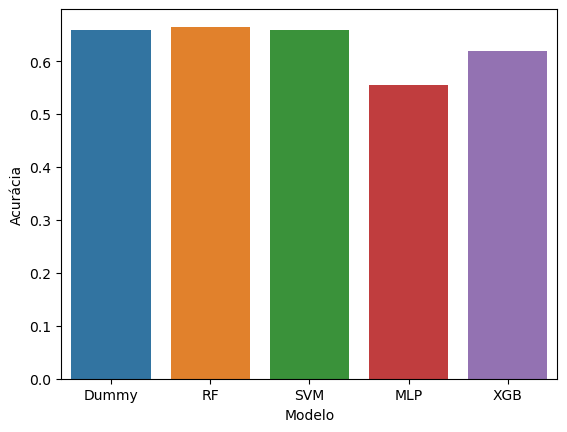

,Modelo,Acurácia
0,Dummy,0.658257
1,RF,0.665138
2,SVM,0.658257
3,MLP,0.555046
4,XGB,0.619266


In [9]:
avalia_dif_modelos_cv(data4, target4, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.00      0.00      0.00       149
           2       0.66      1.00      0.79       574

    accuracy                           0.66       872
   macro avg       0.22      0.33      0.26       872
weighted avg       0.43      0.66      0.52       872

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.02      0.04       149
           1       0.61      0.19      0.29       149
           2       0.67      0.96      0.79       574

    accuracy                           0.67       872
   macro avg       0.55      0.39      0.37       872
weighted avg       0.61      0.67      0.58       872

-------------------

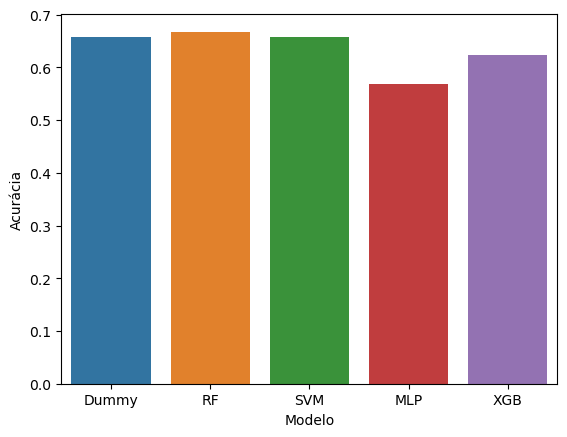

,Modelo,Acurácia
0,Dummy,0.658257
1,RF,0.667431
2,SVM,0.658257
3,MLP,0.567661
4,XGB,0.623853


In [10]:
avalia_dif_modelos_cv(data5, target5, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.00      0.00      0.00       149
           2       0.66      1.00      0.79       574

    accuracy                           0.66       872
   macro avg       0.22      0.33      0.26       872
weighted avg       0.43      0.66      0.52       872

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.13      0.21       149
           1       0.74      0.28      0.41       149
           2       0.70      0.95      0.81       574

    accuracy                           0.70       872
   macro avg       0.69      0.45      0.48       872
weighted avg       0.69      0.70      0.64       872

-------------------

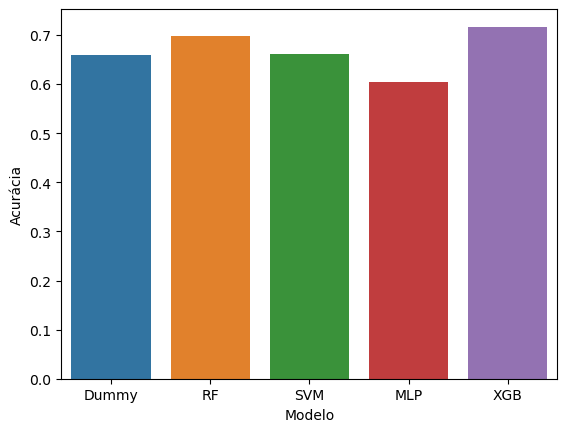

,Modelo,Acurácia
0,Dummy,0.658257
1,RF,0.698394
2,SVM,0.660550
3,MLP,0.603211
4,XGB,0.716743


In [11]:
avalia_dif_modelos_cv(data6, target6, 5)

## Avaliando modelos com Under-Sampling

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.00      0.00      0.00       120
           2       0.66      1.00      0.79       457

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.03      0.05       120
           1       0.33      0.03      0.05       120
           2       0.66      0.98      0.79       457

    accuracy                           0.65       697
   macro avg       0.50      0.34      0.29       697
weighted avg       0.57      0.65      0.53       697

-------------------

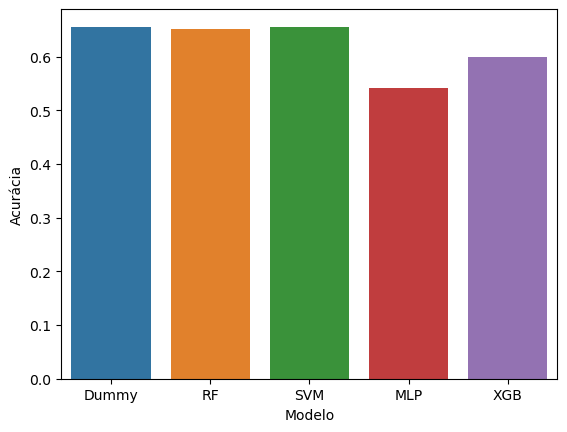

,Modelo,Acurácia
0,Dummy,0.655667
1,RF,0.651363
2,SVM,0.655667
3,MLP,0.542324
4,XGB,0.599713


In [12]:
# Avaliando os modelos para cada dado com o treino
avalia_dif_modelos_cv(X_train1, y_train1, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.00      0.00      0.00       120
           2       0.66      1.00      0.80       460

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.27       697
weighted avg       0.44      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.44      0.54       117
           1       0.78      0.55      0.64       120
           2       0.78      0.91      0.84       460

    accuracy                           0.77       697
   macro avg       0.75      0.64      0.68       697
weighted avg       0.77      0.77      0.76       697

-------------------

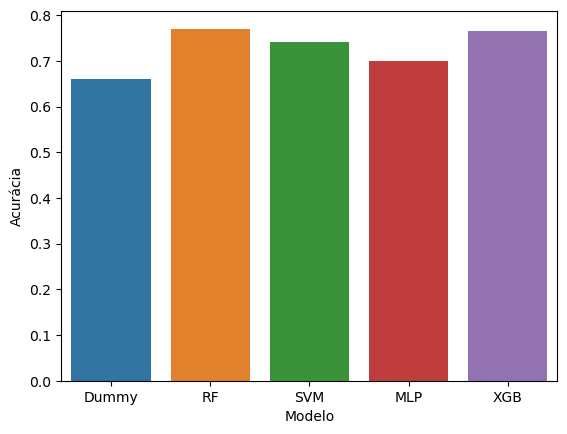

,Modelo,Acurácia
0,Dummy,0.659971
1,RF,0.770445
2,SVM,0.741750
3,MLP,0.698709
4,XGB,0.764706


In [13]:
avalia_dif_modelos_cv(X_train2, y_train2, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       127
           1       0.00      0.00      0.00       107
           2       0.66      1.00      0.80       463

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.27       697
weighted avg       0.44      0.66      0.53       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.33      0.46       127
           1       0.83      0.46      0.59       107
           2       0.75      0.95      0.84       463

    accuracy                           0.76       697
   macro avg       0.78      0.58      0.63       697
weighted avg       0.77      0.76      0.73       697

-------------------

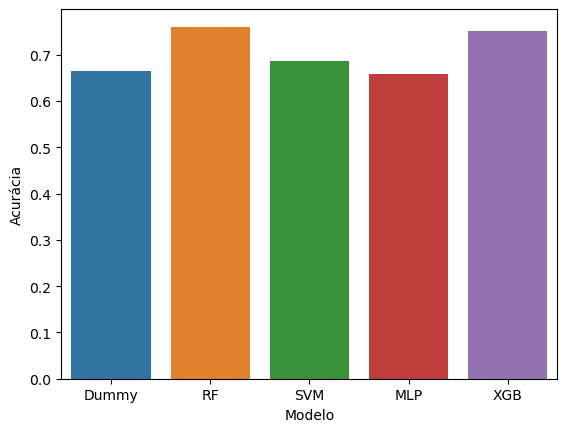

,Modelo,Acurácia
0,Dummy,0.664275
1,RF,0.760402
2,SVM,0.687231
3,MLP,0.658537
4,XGB,0.750359


In [14]:
avalia_dif_modelos_cv(X_train3, y_train3, 5)

In [15]:
#avalia_dif_modelos_cv(X_train4, y_train4, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.00      0.00      0.00       128
           2       0.65      1.00      0.79       456

    accuracy                           0.65       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.65      0.52       697



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.04      0.08       113
           1       0.57      0.22      0.32       128
           2       0.68      0.95      0.79       456

    accuracy                           0.67       697
   macro avg       0.58      0.40      0.40       697
weighted avg       0.63      0.67      0.59       697

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.00      0.00      0.00       128
           2       0.65      1.00      0.79       456

    accuracy                           0.65       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.65      0.52       697

-------------------------------

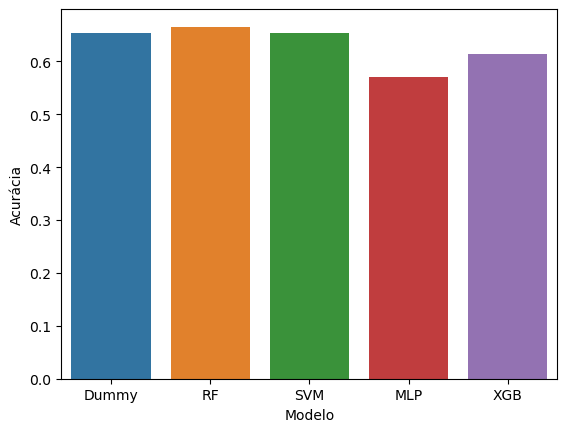

,Modelo,Acurácia
0,Dummy,0.654232
1,RF,0.665710
2,SVM,0.654232
3,MLP,0.571019
4,XGB,0.614060


In [16]:
avalia_dif_modelos_cv(X_train5, y_train5, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       120
           2       0.66      1.00      0.80       461

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.27       697
weighted avg       0.44      0.66      0.53       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.17      0.29       116
           1       0.81      0.33      0.46       120
           2       0.72      0.97      0.83       461

    accuracy                           0.73       697
   macro avg       0.79      0.49      0.53       697
weighted avg       0.75      0.73      0.67       697

-------------------

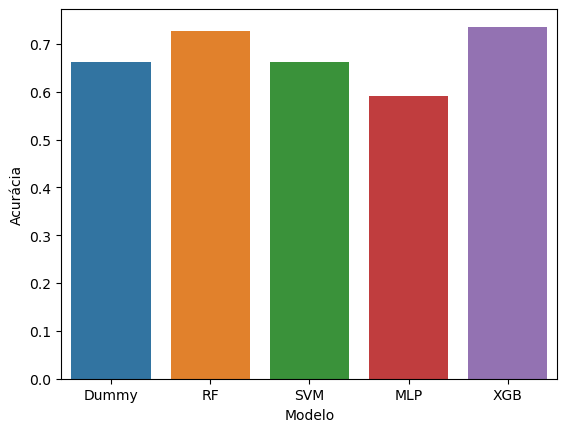

,Modelo,Acurácia
0,Dummy,0.661406
1,RF,0.727403
2,SVM,0.662841
3,MLP,0.591105
4,XGB,0.736011


In [17]:
avalia_dif_modelos_cv(X_train6, y_train6, 5)



In [18]:
# Definindo parametros:
# Definir os modelos e os grids de parâmetros
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'XGBoost': XGBClassifier()
}

param_grids = [
    {
        'model': 'Random Forest',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    },
    {
        'model': 'SVM',
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto']
        }
    },
    {
        'model': 'MLP',
        'params': {
            'hidden_layer_sizes': [(10,), (50,), (100,), (150,), (200,)],
            'activation': ['logistic', 'tanh', 'relu'],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
        }
    },
    {
        'model': 'XGBoost',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [3, 5, 7, 9, 11],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    }
]





In [19]:
# Criando uma função para avaliar os modelos
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_train, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)

In [20]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_predict
import numpy as np


def perform_cross_validation(model, X, y, cv, verbose=True):
    reports = []
    predictions = cross_val_predict(model, X, y, cv=cv)

    for fold in range(cv):
        start = fold * len(X) // cv
        end = (fold + 1) * len(X) // cv
        report = classification_report(y[start:end], predictions[start:end], output_dict=True)
        reports.append(report)

        if verbose:
            print(f"Fold {fold + 1} Classification Report:")
            print(classification_report(y[start:end], predictions[start:end]))
            print("-" * 50)

    avg_report = {
        'precision': np.mean([report['weighted avg']['precision'] for report in reports]),
        'recall': np.mean([report['weighted avg']['recall'] for report in reports]),
        'f1-score': np.mean([report['weighted avg']['f1-score'] for report in reports]),
        'support': np.mean([report['weighted avg']['support'] for report in reports])
    }

    accuracy = accuracy_score(y, predictions)

    if verbose or not verbose:
        print("Average Classification Report:")
        print(classification_report(y, predictions))
        print("-" * 50)
        print(f"Accuracy: {accuracy:.2f}")

    return None


In [21]:
# Chamando função para cada uma das bases
# Aplicando Random Forest no under-sampling com Cross Validation de 10 folds
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier()
modelSVM = SVC()
#avalia_modelo_cv(model, data1_re, target1_re, 5, True)

perform_cross_validation(model, data1_re, target1_re, 5, True)



Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.75      0.09      0.15        35
           2       0.68      0.97      0.80       118

    accuracy                           0.68       174
   macro avg       0.48      0.35      0.32       174
weighted avg       0.62      0.68      0.58       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.50      0.10      0.16        21
           2       0.70      0.97      0.81       121

    accuracy                           0.68       174
   macro avg       0.40      0.35      0.32       174
weighted avg       0.54      0.68      0.58       174

--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   

In [22]:
perform_cross_validation(model, data2_re, target2_re, 5, True)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.38      0.48        21
           1       0.67      0.63      0.65        35
           2       0.80      0.87      0.83       118

    accuracy                           0.76       174
   macro avg       0.71      0.63      0.66       174
weighted avg       0.76      0.76      0.75       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.34      0.48        32
           1       0.78      0.67      0.72        21
           2       0.80      0.94      0.87       121

    accuracy                           0.80       174
   macro avg       0.79      0.65      0.69       174
weighted avg       0.80      0.80      0.78       174

--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   

In [23]:
perform_cross_validation(model, data3_re, target3_re, 5, True)

Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.19      0.28        21
           1       0.77      0.57      0.66        35
           2       0.77      0.92      0.84       118

    accuracy                           0.76       174
   macro avg       0.68      0.56      0.59       174
weighted avg       0.74      0.76      0.73       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.28      0.40        32
           1       0.80      0.57      0.67        21
           2       0.78      0.94      0.85       121

    accuracy                           0.78       174
   macro avg       0.76      0.60      0.64       174
weighted avg       0.77      0.78      0.75       174

--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   

In [24]:
perform_cross_validation(model, data4_re, target4_re, 5, True)

Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.70      0.20      0.31        35
           2       0.70      0.97      0.81       118

    accuracy                           0.70       174
   macro avg       0.47      0.39      0.37       174
weighted avg       0.62      0.70      0.61       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.03      0.06        32
           1       0.45      0.24      0.31        21
           2       0.71      0.93      0.80       121

    accuracy                           0.68       174
   macro avg       0.50      0.40      0.39       174
weighted avg       0.61      0.68      0.61       174

--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   

In [25]:
modelMLP = MLPClassifier()
perform_cross_validation(modelMLP, data5_re, target5_re, 5, True)

Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.10      0.12        21
           1       0.48      0.34      0.40        35
           2       0.69      0.80      0.74       118

    accuracy                           0.62       174
   macro avg       0.44      0.41      0.42       174
weighted avg       0.58      0.62      0.60       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.28      0.30        32
           1       0.44      0.38      0.41        21
           2       0.72      0.75      0.73       121

    accuracy                           0.62       174
   macro avg       0.49      0.47      0.48       174
weighted avg       0.61      0.62      0.61       174

--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   

In [26]:
perform_cross_validation(model, data6_re, target6_re, 5, True)

Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.14      0.23        21
           1       0.82      0.40      0.54        35
           2       0.74      0.96      0.84       118

    accuracy                           0.75       174
   macro avg       0.72      0.50      0.54       174
weighted avg       0.74      0.75      0.70       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.19      0.29        32
           1       0.58      0.33      0.42        21
           2       0.74      0.93      0.82       121

    accuracy                           0.72       174
   macro avg       0.66      0.48      0.51       174
weighted avg       0.71      0.72      0.68       174

--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   

In [27]:
# Chamando função para cada uma das bases
print("========================== Data 1  =================================")
best_models1 = perform_model_tuning(data1, target1, models, param_grids, "data1")
print("========================== Data 2  =================================")
best_models2 = perform_model_tuning(data2, target2, models, param_grids,"data2")
print("========================== Data 3  =================================")
best_models3 = perform_model_tuning(data3, target3, models, param_grids, "data3")
print("========================== Data 4  =================================")
best_models4 = perform_model_tuning(data4, target4, models, param_grids, "data4")
print("========================== Data 5  =================================")
best_models5 = perform_model_tuning(data5, target5, models, param_grids, "data5")
print("========================== Data 6  =================================")
best_models6 = perform_model_tuning(data6, target6, models, param_grids, "data6")

========================== Data 1  =================================
Tuning do modelo Random Forest iniciado...
Acurácia do modelo Random Forest: 0.6686
Tuning do modelo SVM iniciado...
Acurácia do modelo SVM: 0.6514
Tuning do modelo MLP iniciado...
Acurácia do modelo MLP: 0.6629
Tuning do modelo XGBoost iniciado...
Acurácia do modelo XGBoost: 0.6571
========================== Data 2  =================================
Tuning do modelo Random Forest iniciado...
Acurácia do modelo Random Forest: 0.7486
Tuning do modelo SVM iniciado...
Acurácia do modelo SVM: 0.7371
Tuning do modelo MLP iniciado...
Acurácia do modelo MLP: 0.7143
Tuning do modelo XGBoost iniciado...
Acurácia do modelo XGBoost: 0.7600
========================== Data 3  =================================
Tuning do modelo Random Forest iniciado...
Acurácia do modelo Random Forest: 0.7543
Tuning do modelo SVM iniciado...
Acurácia do modelo SVM: 0.7429
Tuning do modelo MLP iniciado...
Acurácia do modelo MLP: 0.7200
Tuning do mod

In [28]:
# Pegar o melhor modelo de cada base, usando max, para em seguida aplicar SBFS e SFFS com cross validation
# para cada um dos modelos
#best_model1 = max(best_models1, key=best_models1.get)
modelo1 = best_models1['Random Forest']

#best_model2 = max(best_models2, key=best_models2.get)
modelo2 = best_models2['XGBoost']

#best_model3 = max(best_models3, key=best_models3.get)
modelo3 = best_models3['Random Forest']

#best_model4 = max(best_models4, key=best_models4.get)
modelo4 = best_models4['XGBoost']

modelo5 = best_models5['MLP']

modelo6 = best_models6['XGBoost']
print(modelo1)
print(modelo2)
print(modelo3)
print(modelo4)
print(modelo5)
print(modelo6)

RandomForestClassifier(max_features='log2', min_samples_split=10,
                       n_estimators=50)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2)
XGBClassifier(base_score=None, booster=None, callbacks=None,


In [29]:
# Salvando modelo1 à 4 em pickle
import pickle
with open('modelo1.pkl', 'wb') as f:
   pickle.dump(modelo1, f)
with open('modelo2.pkl', 'wb') as f:
   pickle.dump(modelo2, f)
with open('modelo3.pkl', 'wb') as f:
   pickle.dump(modelo3, f)
with open('modelo4.pkl', 'wb') as f:
   pickle.dump(modelo4, f)
with open('modelo5.pkl', 'wb') as f:
    pickle.dump(modelo5, f)
with open('modelo6.pkl', 'wb') as f:
    pickle.dump(modelo6, f)

In [8]:
# Importando modelos pickl
import pickle
with open('modelo1.pkl', 'rb') as file:
    modelo1 = pickle.load(file)
    print(f'Modelo1 = \n{modelo1}')
with open('modelo2.pkl', 'rb') as file:
    modelo2 = pickle.load(file)
    print(f'Modelo2 = \n{modelo2}')
with open('modelo3.pkl', 'rb') as file:
    modelo3 = pickle.load(file)
    print(f'Modelo3 = \n{modelo3}')
with open('modelo4.pkl', 'rb') as file:
    modelo4 = pickle.load(file)
    print(f'Modelo4 = \n{modelo4}')
with open('modelo5.pkl', 'rb') as file:
    modelo5 = pickle.load(file)
    print(f'Modelo5 = \n{modelo5}')
with open('modelo6.pkl', 'rb') as file:
    modelo6 = pickle.load(file)
    print(f'Modelo6 = \n{modelo6}')


Modelo1 = 
RandomForestClassifier(max_features='log2', min_samples_split=10,
                       n_estimators=50)
Modelo2 = 
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Modelo3 = 
RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2)
Modelo4 = 
XGBClassifier(bas

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [31]:
# Analisar cross validation para cada um dos modelos
print("========================== Data 1  =================================")
c1 = cross_val_score(modelo1, data1_re, target1_re , cv=5)
print(c1)
print(c1.mean())

perform_cross_validation(modelo1, data1_re, target1_re, 5, True)

========================== Data 1  =================================
[0.65714286 0.65142857 0.66091954 0.65517241 0.65517241]
0.6559671592775042
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       1.00      0.03      0.06        35
           2       0.68      1.00      0.81       118

    accuracy                           0.68       174
   macro avg       0.56      0.34      0.29       174
weighted avg       0.66      0.68      0.56       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       1.00      0.05      0.09        21
           2       0.70      1.00      0.82       121

    accuracy                           0.70       174
   macro avg       0.57      0.35      0.30       174
weighted avg       0.61      0.70    

In [32]:
print("========================== Data 2  =================================")
c2 = cross_val_score(modelo2, data2_re, target2_re, cv=5)
print(c2)
print(c2.mean())

perform_cross_validation(modelo2, data2_re, target2_re, 5, True)

========================== Data 2  =================================
[0.73714286 0.77142857 0.74712644 0.75862069 0.76436782]
0.7557372742200329
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.43      0.50        21
           1       0.65      0.69      0.67        35
           2       0.81      0.84      0.82       118

    accuracy                           0.76       174
   macro avg       0.69      0.65      0.66       174
weighted avg       0.75      0.76      0.75       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.41      0.47        32
           1       0.75      0.71      0.73        21
           2       0.81      0.88      0.84       121

    accuracy                           0.77       174
   macro avg       0.71      0.67      0.68       174
weighted avg       0.76      0.77    

In [33]:
print("========================== Data 3  =================================")
c3 = cross_val_score(modelo3, data3_re, target3_re, cv=5)
print(c3)
print(c3.mean())

perform_cross_validation(modelo3, data3_re, target3_re, 5, True)


========================== Data 3  =================================
[0.73142857 0.75428571 0.74712644 0.77586207 0.70689655]
0.7431198686371101
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.24      0.33        21
           1       0.80      0.57      0.67        35
           2       0.78      0.92      0.84       118

    accuracy                           0.77       174
   macro avg       0.71      0.58      0.61       174
weighted avg       0.76      0.77      0.75       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.22      0.35        32
           1       0.80      0.57      0.67        21
           2       0.77      0.97      0.86       121

    accuracy                           0.78       174
   macro avg       0.82      0.59      0.63       174
weighted avg       0.80      0.78    

In [34]:
print("========================== Data 4  =================================")
c4 = cross_val_score(modelo4, data4_re, target4_re, cv=5)
print(c4)
print(c4.mean())

perform_cross_validation(modelo4, data4_re, target4_re, 5, True)

========================== Data 4  =================================
[0.65142857 0.65142857 0.6954023  0.6954023  0.64367816]
0.6674679802955665
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.10      0.15        21
           1       0.50      0.20      0.29        35
           2       0.70      0.92      0.79       118

    accuracy                           0.67       174
   macro avg       0.53      0.40      0.41       174
weighted avg       0.62      0.67      0.61       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.12      0.21        32
           1       0.36      0.24      0.29        21
           2       0.72      0.91      0.80       121

    accuracy                           0.68       174
   macro avg       0.55      0.42      0.43       174
weighted avg       0.65      0.68    

In [35]:
print("========================== Data 5  =================================")
c5 = cross_val_score(modelo5, data5_re, target5_re, cv=5)
print(c5)
print(c5.mean())

perform_cross_validation(modelo5, data5_re, target5_re, 5, True)

========================== Data 5  =================================
[0.65714286 0.64       0.64942529 0.63218391 0.67241379]
0.6502331691297208
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.05      0.08        21
           1       0.65      0.31      0.42        35
           2       0.71      0.92      0.80       118

    accuracy                           0.70       174
   macro avg       0.54      0.43      0.44       174
weighted avg       0.64      0.70      0.64       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.12      0.19        32
           1       0.50      0.29      0.36        21
           2       0.72      0.90      0.80       121

    accuracy                           0.68       174
   macro avg       0.54      0.44      0.45       174
weighted avg       0.63      0.68    

In [36]:
print("========================== Data 6  =================================")
c6 = cross_val_score(modelo6, data6_re, target6_re, cv=5)
print(c6)
print(c6.mean())

perform_cross_validation(modelo6, data6_re, target6_re, 5, True)

========================== Data 6  =================================
[0.72571429 0.77714286 0.73563218 0.76436782 0.74137931]
0.748847290640394
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.33      0.42        21
           1       0.68      0.60      0.64        35
           2       0.79      0.87      0.83       118

    accuracy                           0.75       174
   macro avg       0.68      0.60      0.63       174
weighted avg       0.74      0.75      0.74       174

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.34      0.47        32
           1       0.67      0.57      0.62        21
           2       0.79      0.92      0.85       121

    accuracy                           0.77       174
   macro avg       0.73      0.61      0.64       174
weighted avg       0.76      0.77     

In [9]:
import matplotlib.pyplot as plt

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Função para aplicar SBFS e SFFS com cross validation e salvar tabela com resultado.
def perform_feature_selection(data, target, model, best_model, method, cv):
    # Criando o objeto de seleção de features
    if method == 'SBFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=False,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=-1)
    elif method == 'SFFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=True,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=-1)
    # Aplicando o método de seleção de features
    sfs = sfs.fit(data, target)
    # Salvando o resultado em um dataframe
    df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Definindo nome do arquivo para salvar as features selecionadas em formato CSV
    if os.path.exists(f"results/{method}_{best_model}.csv"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.csv"):
            i += 1
        file_name_csv = f"results/{method}_{best_model}_{i}.csv"
    else:
        file_name_csv = f"results/{method}_{best_model}.csv"

    # Salvando o dataframe em um arquivo CSV
    df.to_csv(file_name_csv, index=False)

    # Definindo nome do arquivo para salvar as features selecionadas em formato TXT
    if os.path.exists(f"results/{method}_{best_model}.txt"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.txt"):
            i += 1
        file_name_txt = f"results/{method}_{best_model}_{i}.txt"
    else:
        file_name_txt = f"results/{method}_{best_model}.txt"

    # Salvando as features selecionadas e o score em um arquivo TXT
    with open(file_name_txt, 'w') as file:
        file.write(f"Selected Features: {', '.join(sfs.k_feature_names_)}\n")
        file.write(f"Score: {sfs.k_score_}")

    # Plotando o desempenho do modelo para cada combinação de atributos
    fig, ax = plt.subplots()
    ax.plot(range(1, len(df) + 1), df['avg_score'], marker='o')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Average Score')
    ax.set_title('Performance of Model with Feature Selection')
    plt.xticks(range(1, len(df) + 1))
    plt.grid(True)

    # Definindo nome do arquivo para salvar o gráfico
    if os.path.exists(f"results/{method}_{best_model}.png"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.png"):
            i += 1
        file_name_plot = f"results/{method}_{best_model}_{i}.png"
    else:
        file_name_plot = f"results/{method}_{best_model}.png"

    # Salvando o gráfico em um arquivo PNG
    plt.savefig(file_name_plot)

    # Retornando as features selecionadas e o score
    return sfs.k_feature_names_, sfs.k_score_

In [64]:
#Função que muda max_features de auto p sqrt se tiver definido para evitar erro de versão
def updt_maxfeature(modelo):
    try:
        if modelo.get_params()['max_features'] == 'auto':
            modelo.max_features = 'sqrt'
            print(modelo)
    except:
        pass


updt_maxfeature(modelo1)
updt_maxfeature(modelo2)
updt_maxfeature(modelo3)
updt_maxfeature(modelo4)
updt_maxfeature(modelo5)
updt_maxfeature(modelo6)

RandomForestClassifier(min_samples_split=10, n_estimators=400)
RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300)
RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=300)


In [13]:
# Chamando a função de feature selection para cada um dos "modelos*"
print("========================== Data 1  =================================")
slt_sbfs_features1, score1_sbfs = perform_feature_selection(data1, target1, modelo1, "data1", 'SBFS', 5)
slt_sffs_features1, score1_sffs = perform_feature_selection(data1, target1, modelo1, "data1", 'SFFS', 5)
#%%


========================== Data 1  =================================


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

AttributeError: SequentialFeatureSelector has not been fitted, yet.

In [ ]:
print("========================== Data 2  =================================")
slt_sbfs_features2, score2_sbfs = perform_feature_selection(data2, target2, modelo2, "data2", 'SBFS', 5)
slt_sffs_features2, score2_sffs = perform_feature_selection(data2, target2, modelo2,"data2", 'SFFS', 5)

In [ ]:
print("========================== Data 3  =================================")
slt_sbfs_features3, score3_sbfs = perform_feature_selection(data3, target3, modelo3, "data3", 'SBFS', 5)
slt_sffs_features3, score3_sffs = perform_feature_selection(data3, target3, modelo3, "data3", 'SFFS', 5)


In [ ]:

print("========================== Data 4  =================================")
slt_sbfs_features4, score4_sbfs = perform_feature_selection(data4, target4, modelo4,"data4", 'SBFS', 5)
slt_sffs_features4, score4_sffs = perform_feature_selection(data4, target4, modelo4, "data4", 'SFFS', 5)

In [15]:
modelo5.max_iter=2000

In [16]:

print("========================== Data 5  =================================")
slt_sbfs_features5, score5_sbfs = perform_feature_selection(data5, target5, modelo5, "data5", 'SBFS', 5)
slt_sffs_features5, score5_sffs = perform_feature_selection(data5, target5, modelo5, "data5", 'SFFS', 5)

========================== Data 5  =================================


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.1s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

AttributeError: SequentialFeatureSelector has not been fitted, yet.

In [ ]:

print("========================== Data 6  =================================")
slt_sbfs_features6, score6_sbfs = perform_feature_selection(data6, target6, modelo6, "data6", 'SBFS', 5)
slt_sffs_features6, score6_sffs = perform_feature_selection(data6, target6, modelo6, "data6", 'SFFS', 5)

In [12]:
# Criando um arquivo txt com a feature selecionadas
with open(f"results/SBFS_data1.txt", "w") as f:
    f.write(str(slt_sbfs_features1))
with open(f"results/SFFS_data1.txt", "w") as f:
    f.write(str(slt_sffs_features1))
with open(f"results/SBFS_data2.txt", "w") as f:
    f.write(str(slt_sbfs_features2))
with open(f"results/SFFS_data2.txt", "w") as f:
    f.write(str(slt_sffs_features2))
with open(f"results/SBFS_data3.txt", "w") as f:
    f.write(str(slt_sbfs_features3))
with open(f"results/SFFS_data3.txt", "w") as f:
    f.write(str(slt_sffs_features3))
with open(f"results/SBFS_data4.txt", "w") as f:
    f.write(str(slt_sbfs_features4))
with open(f"results/SFFS_data4.txt", "w") as f:
    f.write(str(slt_sffs_features4))
with open(f"results/SBFS_data5.txt", "w") as f:
    f.write(str(slt_sbfs_features5))
with open(f"results/SFFS_data5.txt", "w") as f:
    f.write(str(slt_sffs_features5))
with open(f"results/SBFS_data6.txt", "w") as f:
    f.write(str(slt_sbfs_features6))
with open(f"results/SFFS_data6.txt", "w") as f:
    f.write(str(slt_sffs_features6))

NameError: name 'slt_sffs_features5' is not defined

In [ ]:
# Testando os modelos com as features selecionadas
print("========================== Data 1  - SBFS =================================")
perform_cross_validation(modelo1, data1_re.loc[:,slt_sbfs_features1], target1_re, 5, False)

print("========================== Data 1  - SFFS =================================")
perform_cross_validation(modelo1, data1_re.loc[:,slt_sffs_features1], target1_re, 5, False)

print("========================== Data 2  - SBFS =================================")
perform_cross_validation(modelo2, data2_re.loc[:,slt_sbfs_features2], target2_re, 5, False)

print("========================== Data 2  - SFFS =================================")
perform_cross_validation(modelo2, data2_re.loc[:,slt_sffs_features2], target2_re, 5, False)

print("========================== Data 3  - SBFS =================================")
perform_cross_validation(modelo3, data3_re.loc[:,slt_sbfs_features3], target3_re, 5, False)

print("========================== Data 3  - SFFS =================================")
perform_cross_validation(modelo3, data3_re.loc[:,slt_sffs_features3], target3_re, 5, False)

print("========================== Data 4  - SBFS =================================")
perform_cross_validation(modelo4, data4_re.loc[:,slt_sbfs_features4], target4_re, 5, False)

print("========================== Data 4  - SFFS =================================")
perform_cross_validation(modelo4, data4_re.loc[:,slt_sffs_features4], target4_re, 5, False)

print("========================== Data 5  - SBFS =================================")
perform_cross_validation(modelo5, data5_re.loc[:,slt_sbfs_features5], target5_re, 5, False)

print("========================== Data 5  - SFFS =================================")
perform_cross_validation(modelo5, data5_re.loc[:,slt_sffs_features5], target5_re, 5, False)

print("========================== Data 6  - SBFS =================================")
perform_cross_validation(modelo6, data6_re.loc[:,slt_sbfs_features6], target6_re, 5, False)

print("========================== Data 6  - SFFS =================================")
perform_cross_validation(modelo6, data6_re.loc[:,slt_sffs_features6], target6_re, 5, False)

========================== Data 1  - SBFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.36      0.38       149
           1       0.52      0.56      0.54       149
           2       0.38      0.39      0.39       149

    accuracy                           0.44       447
   macro avg       0.44      0.44      0.44       447
weighted avg       0.44      0.44      0.44       447

--------------------------------------------------
Accuracy: 0.44
========================== Data 1  - SFFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.40      0.45       149
           1       0.52      0.52      0.52       149
           2       0.46      0.58      0.51       149

    accuracy                           0.50       447
   macro avg       0.50      0.50      0.50       447
weighted avg 

In [ ]:

#print("========================== Data 1  =================================")
#X_train, X_test, y_train, y_test = train_test_split(data1, target1, test_size=0.2)
#tpot = TPOTClassifier(verbosity=2, config_dict='TPOT light')
#tpot.fit(X_train, y_train)
#accuracy = tpot.score(X_test, y_test)
#print(f"Acurácia do melhor modelo encontrado: {accuracy}")
#tpot.export('tpot_best_model1.py')
#print("========================== Data 2  =================================")
#X_train, X_test, y_train, y_test = train_test_split(data2, target2, test_size=0.2)
#tpot2 = TPOTClassifier(verbosity=2, config_dict='TPOT light')
#tpot2.fit(X_train, y_train)
#accuracy = tpot2.score(X_test, y_test)
#print(f"Acurácia do melhor modelo encontrado: {accuracy}")
##tpot2.export('tpot_best_model2.py')
#print("========================== Data 3  =================================")
#X_train, X_test, y_train, y_test = train_test_split(data3, target3, test_size=0.2)
#tpot3 = TPOTClassifier(verbosity=2, config_dict='TPOT light')
#tpot3.fit(X_train, y_train)
#accuracy = tpot3.score(X_test, y_test)
#print(f"Acurácia do melhor modelo encontrado: {accuracy}")
#tpot3.export('tpot_best_model3.py')
#print("========================== Data 4  =================================")
#X_train, X_test, y_train, y_test = train_test_split(data4, target4, test_size=0.2)
#$tpot4 = TPOTClassifier(verbosity=2,config_dict='TPOT light')
#tpot4.fit(X_train, y_train)
#accuracy = tpot4.score(X_test, y_test)
#print(f"Acurácia do melhor modelo encontrado: {accuracy}")
#tpot4.export('tpot_best_model4.py')